<a href="https://colab.research.google.com/github/wnubhav/wimbledon-predictor/blob/main/wimbledon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score,classification_report
import xgboost as xgb


In [83]:
df_2022 = pd.read_csv('/content/Wimbledon_Mens_2022.csv')
df_2023 = pd.read_csv('/content/Wimbledon_Mens_2023.csv')
df_2024 = pd.read_csv('/content/Wimbledon_Mens_2024.csv')

df_2022['year'] = 2022
df_2023['year'] = 2023
df_2024['year'] = 2024

df = pd.concat([df_2022, df_2023, df_2024], ignore_index=True)

print(df.shape)

(381, 29)


In [84]:
df

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,W3,L3,W4,L4,W5,L5,Wsets,Lsets,Comment,year
0,39,London,Wimbledon,27-06-2022,Grand Slam,Outdoor,Grass,1st Round,5,Basilashvili N.,...,3.0,6.0,6.0,3.0,6.0,3.0,3.0,2.0,Completed,2022
1,39,London,Wimbledon,27-06-2022,Grand Slam,Outdoor,Grass,1st Round,5,Halys Q.,...,6.0,2.0,6.0,4.0,NaN,NaN,3.0,1.0,Completed,2022
2,39,London,Wimbledon,27-06-2022,Grand Slam,Outdoor,Grass,1st Round,5,Humbert U.,...,4.0,6.0,6.0,3.0,6.0,4.0,3.0,2.0,Completed,2022
3,39,London,Wimbledon,27-06-2022,Grand Slam,Outdoor,Grass,1st Round,5,Ruud C.,...,6.0,2.0,NaN,NaN,NaN,NaN,3.0,0.0,Completed,2022
4,39,London,Wimbledon,27-06-2022,Grand Slam,Outdoor,Grass,1st Round,5,Marterer M.,...,6.0,4.0,7.0,5.0,NaN,NaN,3.0,1.0,Completed,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,39,London,Wimbledon,10-07-2024,Grand Slam,Outdoor,Grass,Quarterfinals,5,Djokovic N.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Walkover,2024
377,39,London,Wimbledon,10-07-2024,Grand Slam,Outdoor,Grass,Quarterfinals,5,Musetti L.,...,6.0,2.0,3.0,6.0,6.0,1.0,3.0,2.0,Completed,2024
378,39,London,Wimbledon,12-07-2024,Grand Slam,Outdoor,Grass,Semifinals,5,Alcaraz C.,...,6.0,4.0,6.0,4.0,NaN,NaN,3.0,1.0,Completed,2024
379,39,London,Wimbledon,12-07-2024,Grand Slam,Outdoor,Grass,Semifinals,5,Djokovic N.,...,6.0,4.0,NaN,NaN,NaN,NaN,3.0,0.0,Completed,2024


In [85]:
df.to_csv('wimbledon_mens_2022_2024.csv', index=False)

In [86]:
df=pd.read_csv('/content/wimbledon_mens_2022_2024.csv')

In [87]:
df[['W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5']] = df[['W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5']].fillna(0)

df = df[df['Comment'] == 'Completed']

In [88]:
# Create rank and points differences
df['Rank_Diff'] = df['WRank'] - df['LRank']
df['Points_Diff'] = df['WPts'] - df['LPts']

# Calculate win rates for each player
player_wins = df.groupby('Winner').size()
player_losses = df.groupby('Loser').size()
player_matches = player_wins.add(player_losses, fill_value=0)
player_win_rate = player_wins / player_matches
df['Winner_Win_Rate'] = df['Winner'].map(player_win_rate).fillna(0)
df['Loser_Win_Rate'] = df['Loser'].map(player_win_rate).fillna(0)

In [89]:
df

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,W5,L5,Wsets,Lsets,Comment,year,Rank_Diff,Points_Diff,Winner_Win_Rate,Loser_Win_Rate
0,39,London,Wimbledon,27-06-2022,Grand Slam,Outdoor,Grass,1st Round,5,Basilashvili N.,...,6.0,3.0,3.0,2.0,Completed,2022,-254,1292,0.666667,0.00
1,39,London,Wimbledon,27-06-2022,Grand Slam,Outdoor,Grass,1st Round,5,Halys Q.,...,0.0,0.0,3.0,1.0,Completed,2022,9,-84,0.625000,0.00
2,39,London,Wimbledon,27-06-2022,Grand Slam,Outdoor,Grass,1st Round,5,Humbert U.,...,6.0,4.0,3.0,2.0,Completed,2022,35,-229,0.625000,0.40
3,39,London,Wimbledon,27-06-2022,Grand Slam,Outdoor,Grass,1st Round,5,Ruud C.,...,0.0,0.0,3.0,0.0,Completed,2022,-33,3970,0.500000,0.00
4,39,London,Wimbledon,27-06-2022,Grand Slam,Outdoor,Grass,1st Round,5,Marterer M.,...,0.0,0.0,3.0,1.0,Completed,2022,-28,36,0.500000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,39,London,Wimbledon,09-07-2024,Grand Slam,Outdoor,Grass,Quarterfinals,5,Alcaraz C.,...,0.0,0.0,3.0,1.0,Completed,2024,-10,5030,0.944444,0.75
377,39,London,Wimbledon,10-07-2024,Grand Slam,Outdoor,Grass,Quarterfinals,5,Musetti L.,...,6.0,1.0,3.0,2.0,Completed,2024,13,-1730,0.700000,0.75
378,39,London,Wimbledon,12-07-2024,Grand Slam,Outdoor,Grass,Semifinals,5,Alcaraz C.,...,0.0,0.0,3.0,1.0,Completed,2024,-2,1685,0.944444,0.80
379,39,London,Wimbledon,12-07-2024,Grand Slam,Outdoor,Grass,Semifinals,5,Djokovic N.,...,0.0,0.0,3.0,0.0,Completed,2024,-23,6740,0.900000,0.70


In [90]:
# Randomly assign Player 1 and Player 2 to avoid bias
df['Player1'] = np.where(np.random.rand(len(df)) > 0.5, df['Winner'], df['Loser'])
df['Player2'] = np.where(df['Player1'] == df['Winner'], df['Loser'], df['Winner'])
df['Player1_Won'] = np.where(df['Player1'] == df['Winner'], 1, 0)

# Map features for Player1 and Player2
df['Player1_Rank'] = np.where(df['Player1'] == df['Winner'], df['WRank'], df['LRank'])
df['Player2_Rank'] = np.where(df['Player1'] == df['Winner'], df['LRank'], df['WRank'])
df['Player1_Pts'] = np.where(df['Player1'] == df['Winner'], df['WPts'], df['LPts'])
df['Player2_Pts'] = np.where(df['Player1'] == df['Winner'], df['LPts'], df['WPts'])

In [91]:
#train on 2022 & 2023; val on 2024
train_df = df[df['year'].isin([2022, 2023])]
val_df = df[df['year'] == 2024]

In [92]:
features = ['Player1_Rank', 'Player2_Rank', 'Player1_Pts', 'Player2_Pts', 'Rank_Diff', 'Points_Diff', 'Winner_Win_Rate', 'Loser_Win_Rate']
X_train = train_df[features]
y_train = train_df['Player1_Won']
X_val = val_df[features]
y_val = val_df['Player1_Won']

In [93]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on validation set
y_pred = xgb_model.predict(X_val)

# Evaluate the model
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val,y_pred))

Accuracy: 0.9256198347107438
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92        55
           1       0.94      0.92      0.93        66

    accuracy                           0.93       121
   macro avg       0.92      0.93      0.93       121
weighted avg       0.93      0.93      0.93       121



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:20:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [94]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
xgb_model = grid_search.best_estimator_

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:20:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:20:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:20:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:20:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:20:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best Parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200}


In [99]:
#list of players who played in W2024
players_2024 = pd.concat([df[df['year'] == 2024][['Winner', 'WRank', 'WPts']].rename(columns={'Winner': 'Player', 'WRank': 'Rank', 'WPts': 'Points'}),
                          df[df['year'] == 2024][['Loser', 'LRank', 'LPts']].rename(columns={'Loser': 'Player', 'LRank': 'Rank', 'LPts': 'Points'})])
players_2024 = players_2024.groupby('Player').agg({'Rank': 'min', 'Points': 'max'}).reset_index()

In [101]:
players_2024

,Player,Rank,Points
0,Albot R.,144,406
1,Alcaraz C.,3,8130
2,Altmaier D.,80,731
3,Arnaldi M.,35,1245
4,Auger-Aliassime F.,17,2075
...,...,...,...
122,Walton A.,101,607
123,Wawrinka S.,95,633
124,Ymer E.,205,293
125,Zhang Zh.,38,1221


In [104]:
import random

# Select top 128 players by rank
players = players_2024.sort_values('Rank').head(128)

# Function to simulate a match
def simulate_match(player1, player2, model, players_data):
    # Prepare features for the match
    match_data = pd.DataFrame({
        'Player1_Rank': [players_data[players_data['Player'] == player1]['Rank'].iloc[0]],
        'Player2_Rank': [players_data[players_data['Player'] == player2]['Rank'].iloc[0]],
        'Player1_Pts': [players_data[players_data['Player'] == player1]['Points'].iloc[0]],
        'Player2_Pts': [players_data[players_data['Player'] == player2]['Points'].iloc[0]],
        'Rank_Diff': [players_data[players_data['Player'] == player1]['Rank'].iloc[0] - players_data[players_data['Player'] == player2]['Rank'].iloc[0]],
        'Points_Diff': [players_data[players_data['Player'] == player1]['Points'].iloc[0] - players_data[players_data['Player'] == player2]['Points'].iloc[0]],
        'Winner_Win_Rate': [player_win_rate.get(player1, 0)],
        'Loser_Win_Rate': [player_win_rate.get(player2, 0)]
    })
    prob = model.predict_proba(match_data)[0][1]  # Probability Player1 wins
    return player1 if random.random() < prob else player2

# Simulate tournament
def simulate_tournament(players, model, players_data):
    current_players = players['Player'].tolist()
    round_num = 1
    while len(current_players) > 1:
        print(f"Round {round_num}: {len(current_players)} players")
        next_round = []
        random.shuffle(current_players)  # Randomize for simplicity
        for i in range(0, len(current_players), 2):
            if i + 1 < len(current_players):
                winner = simulate_match(current_players[i], current_players[i + 1], model, players_data)
                next_round.append(winner)
        current_players = next_round
        round_num += 1
    return current_players[0]

# Run simulation
winner = simulate_tournament(players, xgb_model, players_2024)
display(HTML(f"<h2>🏆 Predicted 2025 Wimbledon Winner: <strong style='color:green;'>{winner.upper()}</strong></h2>"))

Round 1: 127 players
Round 2: 63 players
Round 3: 31 players
Round 4: 15 players
Round 5: 7 players
Round 6: 3 players


In [105]:
# Simulate multiple times
winners = [simulate_tournament(players, xgb_model, players_2024) for _ in range(1000)]
winner_counts = pd.Series(winners).value_counts()
print("Most Frequent Predicted Winners:\n", winner_counts.head())

Streaming output truncated to the last 5000 lines.
Round 6: 3 players
Round 1: 127 players
Round 2: 63 players
Round 3: 31 players
Round 4: 15 players
Round 5: 7 players
Round 6: 3 players
Round 1: 127 players
Round 2: 63 players
Round 3: 31 players
Round 4: 15 players
Round 5: 7 players
Round 6: 3 players
Round 1: 127 players
Round 2: 63 players
Round 3: 31 players
Round 4: 15 players
Round 5: 7 players
Round 6: 3 players
Round 1: 127 players
Round 2: 63 players
Round 3: 31 players
Round 4: 15 players
Round 5: 7 players
Round 6: 3 players
Round 1: 127 players
Round 2: 63 players
Round 3: 31 players
Round 4: 15 players
Round 5: 7 players
Round 6: 3 players
Round 1: 127 players
Round 2: 63 players
Round 3: 31 players
Round 4: 15 players
Round 5: 7 players
Round 6: 3 players
Round 1: 127 players
Round 2: 63 players
Round 3: 31 players
Round 4: 15 players
Round 5: 7 players
Round 6: 3 players
Round 1: 127 players
Round 2: 63 players
Round 3: 31 players
Round 4: 15 players
Round 5: 7 playe

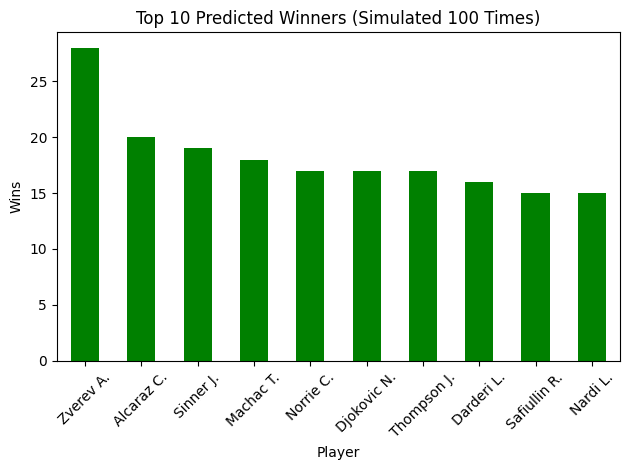

In [106]:
import matplotlib.pyplot as plt

winner_counts.head(10).plot(kind='bar', color='green')
plt.title("Top 10 Predicted Winners (Simulated 100 Times)")
plt.ylabel("Wins")
plt.xlabel("Player")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
